In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib

try:
    data_filtered = pd.read_csv("Golden_CortesCompletosFD2.csv")
except FileNotFoundError:
    print("Error: El archivo no fue encontrado.")
    print("Por favor, asegúrate de que el archivo esté en el directorio correcto.")
    exit()

# Preprocesamiento
data_filtered.fillna(data_filtered.median(numeric_only=True), inplace=True)

X = data_filtered.drop(columns=["FD_RS_fEnergy","FD_RS_fXmax", "FD_RS_fXmaxError","sigma_Xmax","sigma_XmaxError"])
y = pd.DataFrame()
y["FD_RS_fXmax"] = data_filtered["FD_RS_fXmax"]
y["FD_RS_fXmaxError"] = data_filtered["FD_RS_fXmaxError"]
y["log10_CombinedEnergy"] = np.log10(data_filtered["FD_RS_fEnergy"])
y["sigma_Xmax"] = data_filtered["sigma_Xmax"]
y["sigma_XmaxError"] = data_filtered["sigma_XmaxError"]

# Añadir características físicas
X['logE'] = y["log10_CombinedEnergy"]
X['logE_squared'] = X['logE']**2
X['logE_cubed'] = X['logE']**3

print("Creando la característica NUMÉRICA 'energy_bin'...")
energy_bins_for_feature = np.array([18.5, 19.0, 19.3, 19.5, 19.7, 19.8, 19.9, 20.0, np.inf])
X['energy_bin'] = np.digitize(y["log10_CombinedEnergy"], bins=energy_bins_for_feature)

# Definir pesos específicos para cada target
def create_sample_weights(energies, target_name):
    """Crear pesos específicos para cada variable objetivo"""
    if target_name == "log10_CombinedEnergy":
        return np.where(energies >= 19.9, 30.0, np.where(energies >= 19.7, 15.0, np.where(energies >= 19.5, 3.0, 1.0)))
    elif target_name in ["sigma_Xmax", "sigma_XmaxError"]:
        return np.where(energies >= 19.7, 25.0, np.where(energies >= 19.5, 10.0, np.where(energies >= 19.3, 5.0, 1.0)))
    else:
        return np.where(energies >= 19.7, 10.0, np.where(energies >= 19.5, 3.0, 1.0))

weights_dict = {target: create_sample_weights(y["log10_CombinedEnergy"], target) for target in y.columns if target != "sample_weight"}

# Selección de columnas para escalar
scaler = StandardScaler()
cols_to_scale = [col for col in X.columns if col not in ['logE', 'logE_squared', 'logE_cubed', 'energy_bin']]

# División de datos estratificada
bins = np.array([18.5, 19.0, 19.3, 19.5, 19.7, 19.8, 19.9, 20.0, np.inf])
y_binned = np.digitize(y["log10_CombinedEnergy"], bins)
X_train, X_test, y_train_full, y_test_full = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y_binned)

# Escalar los datos
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])
joblib.dump(scaler, 'scaler.pkl')

# Extraer energías
train_energies = y_train_full["log10_CombinedEnergy"].values
test_energies = y_test_full["log10_CombinedEnergy"].values


# --- 
sigma_features_to_drop = ['logE', 'logE_squared', 'logE_cubed']
X_train_for_sigma = X_train_scaled.drop(columns=sigma_features_to_drop)
X_test_for_sigma = X_test_scaled.drop(columns=sigma_features_to_drop)


X_train_no_bin = X_train_scaled.drop(columns=['energy_bin'])
X_test_no_bin = X_test_scaled.drop(columns=['energy_bin'])

# El set para la ENERGÍA es un caso especial del set sin bin (quitamos también sus propias features)
energy_features_to_drop = ['logE', 'logE_squared', 'logE_cubed']
X_train_for_energy = X_train_no_bin.drop(columns=energy_features_to_drop)
X_test_for_energy = X_test_no_bin.drop(columns=energy_features_to_drop)

# --- 


# Definir los objetivos finales
target_names = ["FD_RS_fXmax", "FD_RS_fXmaxError", "log10_CombinedEnergy", "sigma_Xmax", "sigma_XmaxError"]
y_train = y_train_full[target_names]
y_test = y_test_full[target_names]

# Modelo Híbrido 
class ImprovedHybridModel:
    def __init__(self, target_name):
        self.target_name = target_name
        self.xgb = XGBRegressor(objective="reg:squarederror", learning_rate=0.05, max_depth=6 if target_name in ["sigma_Xmax", "sigma_XmaxError"] else 8, min_child_weight=5, subsample=0.8, colsample_bytree=0.7, gamma=1, reg_alpha=0.5, reg_lambda=1, n_estimators=400, random_state=42)
        self.linear = make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=1.0))
        if target_name in ["sigma_Xmax", "sigma_XmaxError"]: self.threshold, self.extrapolation_threshold = 19.5, 19.7
        else: self.threshold, self.extrapolation_threshold = 19.7, 19.9
    def fit(self, X, y, energies, sample_weight=None):
        self.xgb.fit(X, y, sample_weight=sample_weight)
        high_energy_mask = energies >= self.threshold
        if sum(high_energy_mask) > 5:
            if sample_weight is not None: self.linear.fit(X[high_energy_mask], y[high_energy_mask], **{'ridge__sample_weight': sample_weight[high_energy_mask]})
            else: self.linear.fit(X[high_energy_mask], y[high_energy_mask])
    def predict(self, X, energies):
        xgb_pred = self.xgb.predict(X)
        if hasattr(self.linear, 'predict'):
            linear_pred = self.linear.predict(X)
            extrap_mask = energies >= self.extrapolation_threshold
            xgb_pred[extrap_mask] = linear_pred[extrap_mask]
            high_mask = (energies >= self.threshold) & (energies < self.extrapolation_threshold)
            if self.target_name in ["sigma_Xmax", "sigma_XmaxError"]:
                alpha = np.clip((energies[high_mask] - self.threshold) / (self.extrapolation_threshold - self.threshold), 0, 1)
                xgb_pred[high_mask] = (1 - alpha) * xgb_pred[high_mask] + alpha * linear_pred[high_mask]
            else: xgb_pred[high_mask] = 0.3 * xgb_pred[high_mask] + 0.7 * linear_pred[high_mask]
        if self.target_name == "sigma_Xmax": xgb_pred = np.clip(xgb_pred, 15, 80)
        elif self.target_name == "sigma_XmaxError": xgb_pred = np.clip(xgb_pred, 5, 40)
        return xgb_pred

# Bucle de entrenamiento y guardado de modelos
hybrid_models = {}
print("\n=== ENTRENAMIENTO DEL MODELO HÍBRIDO MEJORADO ===")
for target in target_names:
    print(f"\n--- Entrenando modelo híbrido para {target} ---")
    model = ImprovedHybridModel(target)
    
    # --- 
    if target in ["sigma_Xmax", "sigma_XmaxError"]:
        current_X_train = X_train_for_sigma.values
        print(f"   Usando conjunto para sigmas CON 'energy_bin' ({current_X_train.shape[1]} características)")
    elif target == "log10_CombinedEnergy":
        current_X_train = X_train_for_energy.values
        print(f"   Usando conjunto para energía SIN 'energy_bin' ({current_X_train.shape[1]} características)")
    else: # Para FD_RS_fXmax y FD_RS_fXmaxError
        current_X_train = X_train_no_bin.values
        print(f"   Usando conjunto físico SIN 'energy_bin' ({current_X_train.shape[1]} características)")
    # --- 
    weights = weights_dict[target][y_train_full.index] if target in weights_dict else None
    model.fit(current_X_train, y_train[target].values, train_energies, sample_weight=weights)
    hybrid_models[target] = model
    joblib.dump(model, f'HM4CC_{target}.pkl')
    print(f"   Modelo para {target} guardado en 'HM4CC_{target}.pkl'")

# Predicción y Evaluación
y_pred_df = pd.DataFrame(columns=target_names, index=y_test.index)
for target, model in hybrid_models.items():
    print(f"\n--- Prediciendo para {target} ---")
    
    # ---
    if target in ["sigma_Xmax", "sigma_XmaxError"]:
        current_X_test = X_test_for_sigma.values
    elif target == "log10_CombinedEnergy":
        current_X_test = X_test_for_energy.values
    else: # Para FD_RS_fXmax y FD_RS_fXmaxError
        current_X_test = X_test_no_bin.values
    # --- 
        
    y_pred_df[target] = model.predict(current_X_test, test_energies)


print("\n" + "="*60)
print("EVALUACIÓN GENERAL DEL MODELO HÍBRIDO MEJORADO")
print("="*60)
for i, target in enumerate(target_names):
    print(f"\n--- {target} ---")
    r2, mae, rmse = r2_score(y_test.iloc[:, i], y_pred_df.iloc[:, i]), mean_absolute_error(y_test.iloc[:, i], y_pred_df.iloc[:, i]), np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred_df.iloc[:, i]))
    print(f"R²: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

print("\n" + "="*50)
print("EVALUACIÓN ESPECÍفICA PARA SIGMAS")
print("="*50)
for target in ["sigma_Xmax", "sigma_XmaxError"]:
    print(f"\n--- {target} ---")
    r2, mae, rmse = r2_score(y_test[target], y_pred_df[target]), mean_absolute_error(y_test[target], y_pred_df[target]), np.sqrt(mean_squared_error(y_test[target], y_pred_df[target]))
    print(f"R²: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    for e_min, e_max in [(18.5, 19.0), (19.0, 19.3), (19.3, 19.5), (19.5, 19.7), (19.7, 20.0)]:
        mask = (test_energies >= e_min) & (test_energies < e_max)
        if sum(mask) > 0:
            r2_range, mae_range = r2_score(y_test[target][mask], y_pred_df[target][mask]), mean_absolute_error(y_test[target][mask], y_pred_df[target][mask])
            print(f"  {e_min}-{e_max}: R²={r2_range:.3f}, MAE={mae_range:.3f} (n={sum(mask)})")

Creando la característica NUMÉRICA 'energy_bin'...

=== ENTRENAMIENTO DEL MODELO HÍBRIDO MEJORADO ===

--- Entrenando modelo híbrido para FD_RS_fXmax ---
   Usando conjunto físico SIN 'energy_bin' (77 características)
   Modelo para FD_RS_fXmax guardado en 'HM4CC_FD_RS_fXmax.pkl'

--- Entrenando modelo híbrido para FD_RS_fXmaxError ---
   Usando conjunto físico SIN 'energy_bin' (77 características)
   Modelo para FD_RS_fXmaxError guardado en 'HM4CC_FD_RS_fXmaxError.pkl'

--- Entrenando modelo híbrido para log10_CombinedEnergy ---
   Usando conjunto para energía SIN 'energy_bin' (74 características)
   Modelo para log10_CombinedEnergy guardado en 'HM4CC_log10_CombinedEnergy.pkl'

--- Entrenando modelo híbrido para sigma_Xmax ---
   Usando conjunto para sigmas CON 'energy_bin' (75 características)
   Modelo para sigma_Xmax guardado en 'HM4CC_sigma_Xmax.pkl'

--- Entrenando modelo híbrido para sigma_XmaxError ---
   Usando conjunto para sigmas CON 'energy_bin' (75 características)
   Mode


GENERANDO VISUALIZACIONES


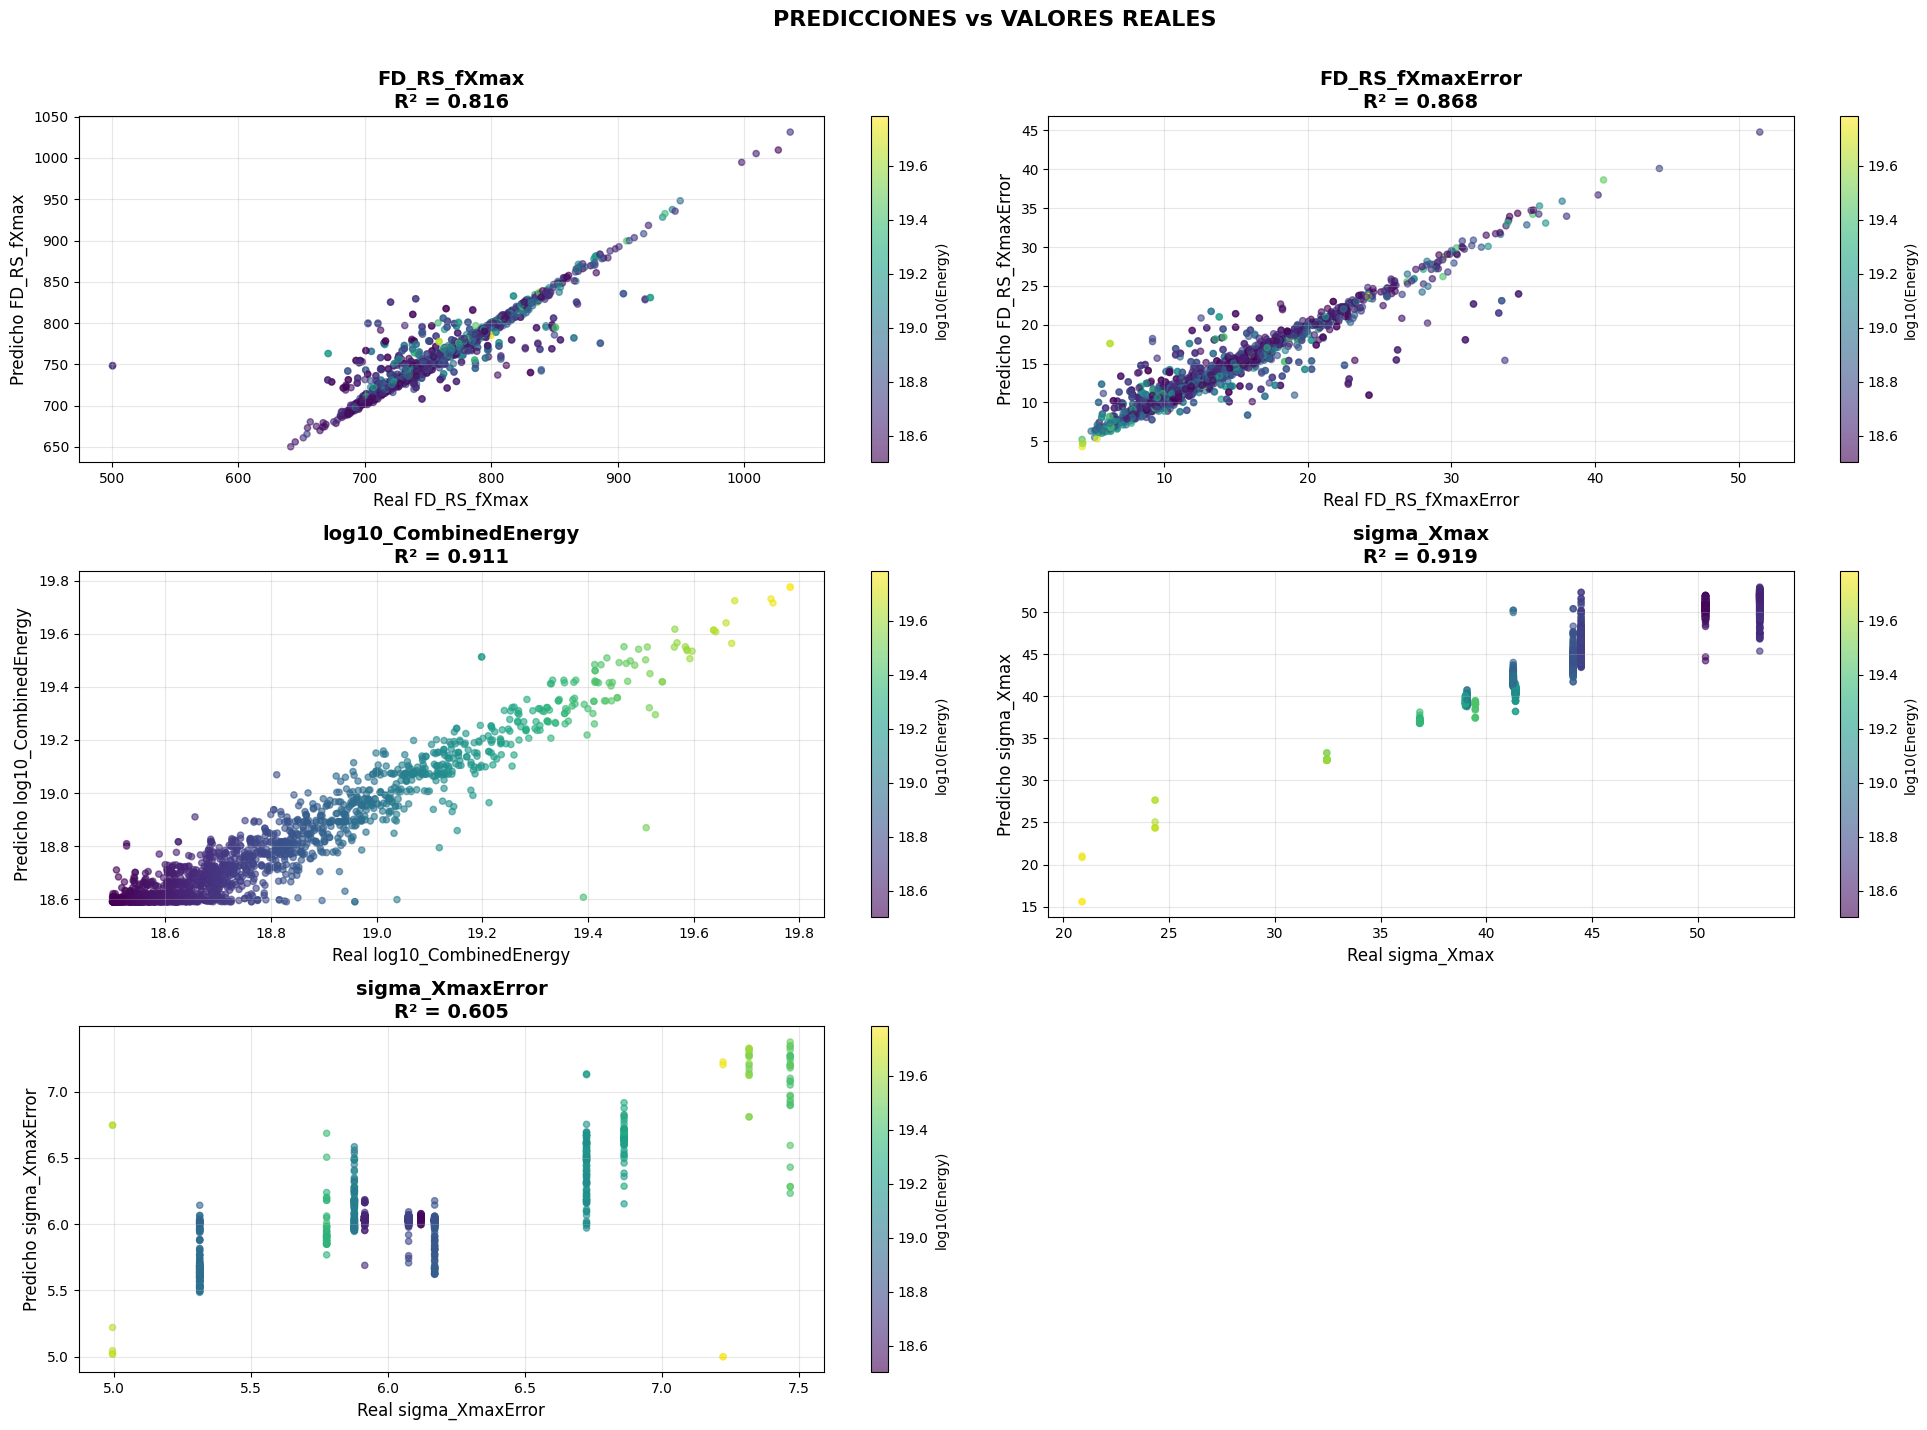

Gráfica 'prediccion_vs_real.png' guardada.
Gráfica 'analisis_residuales.png' guardada.
Gráfica 'evolucion_con_energia.png' guardada.


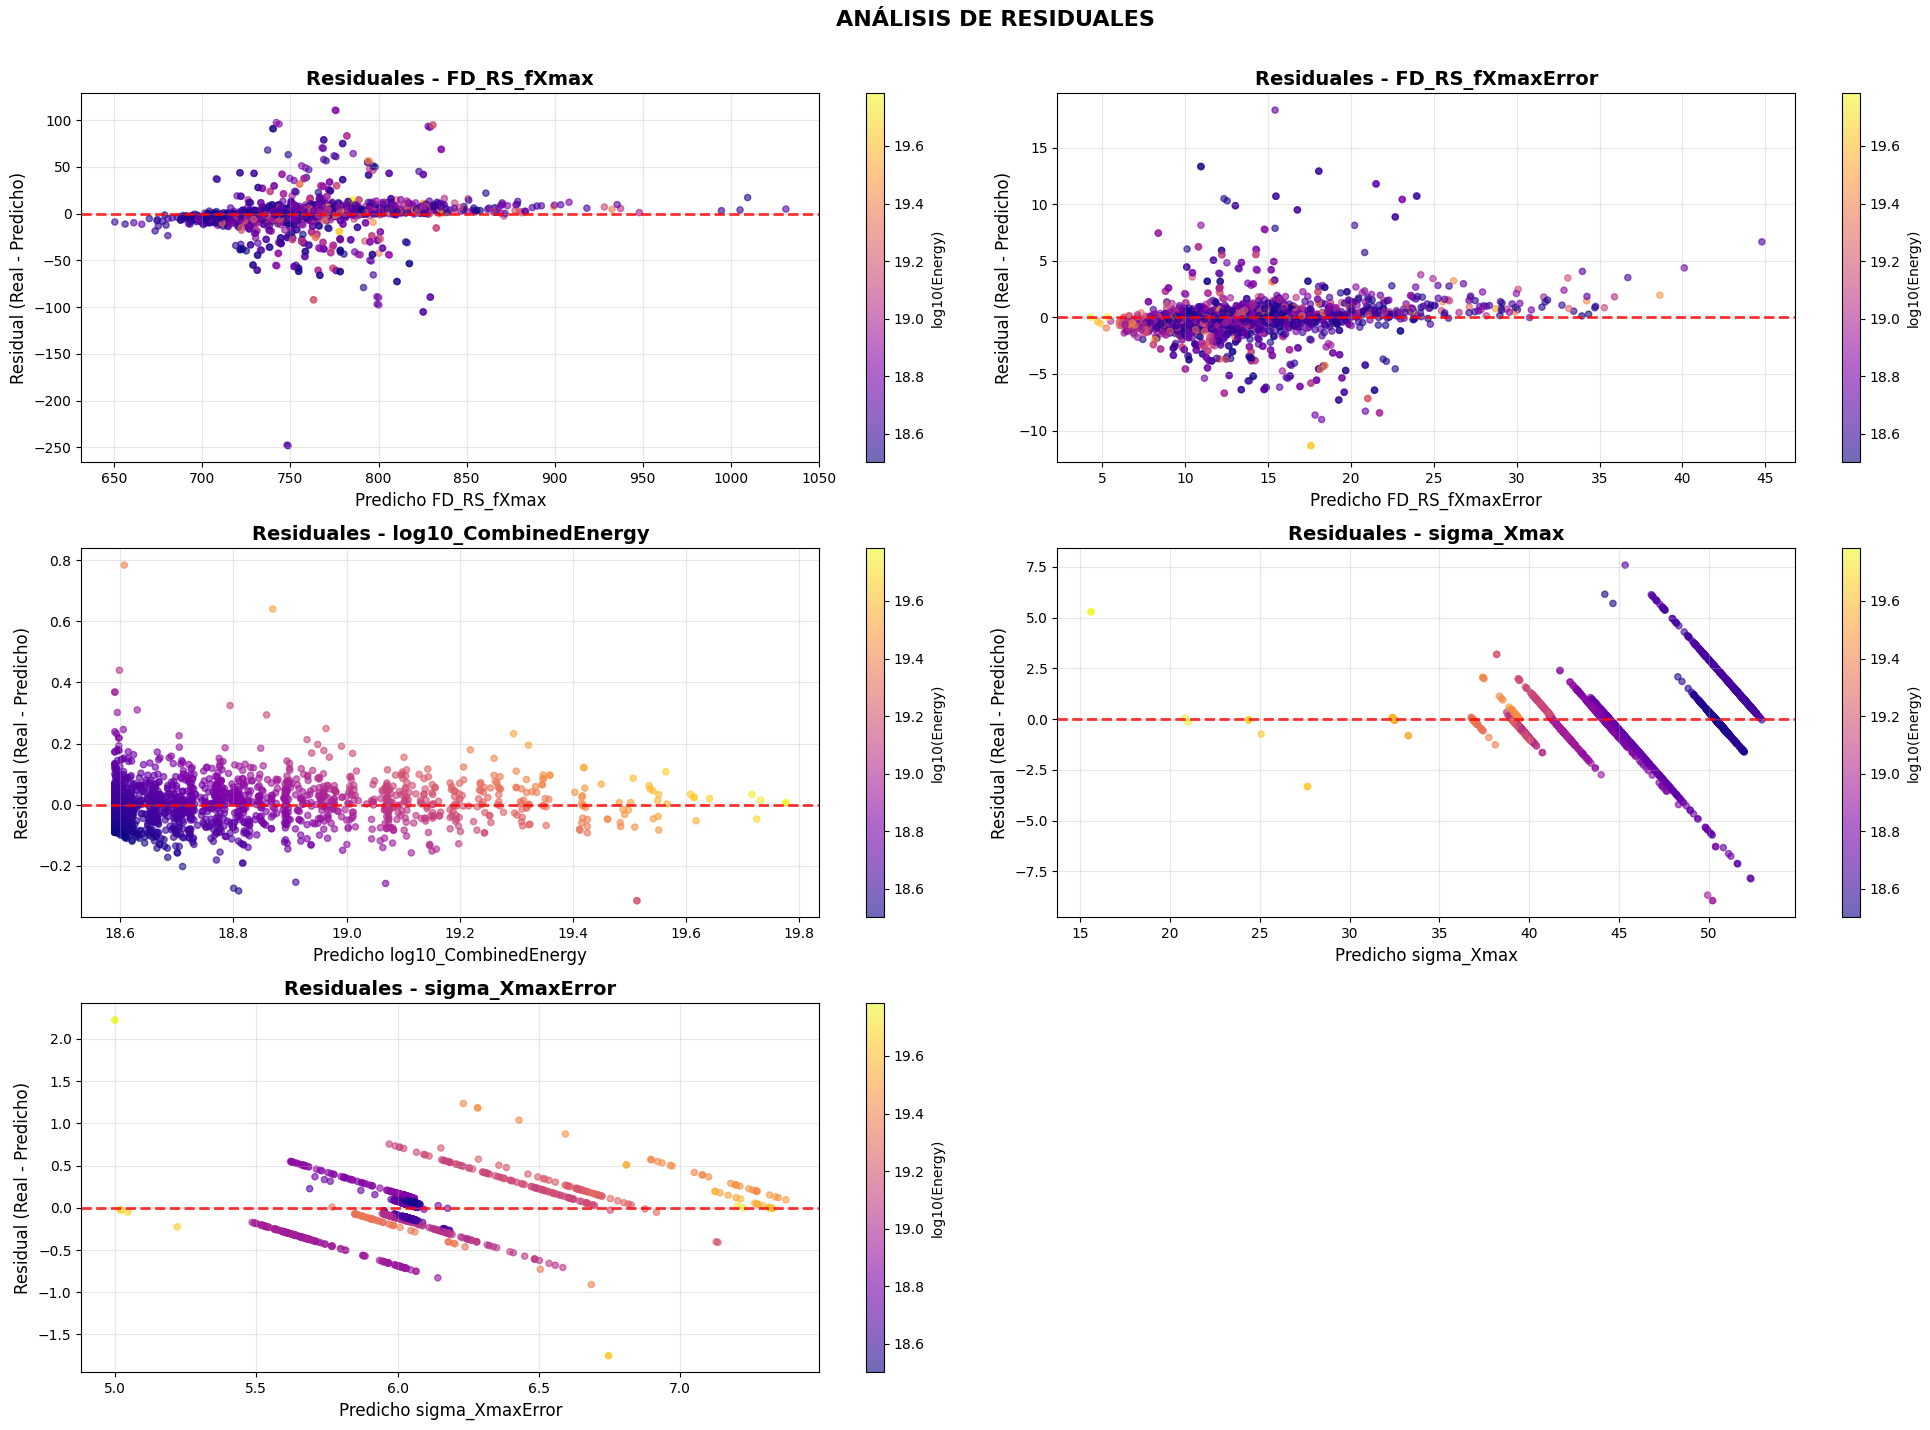

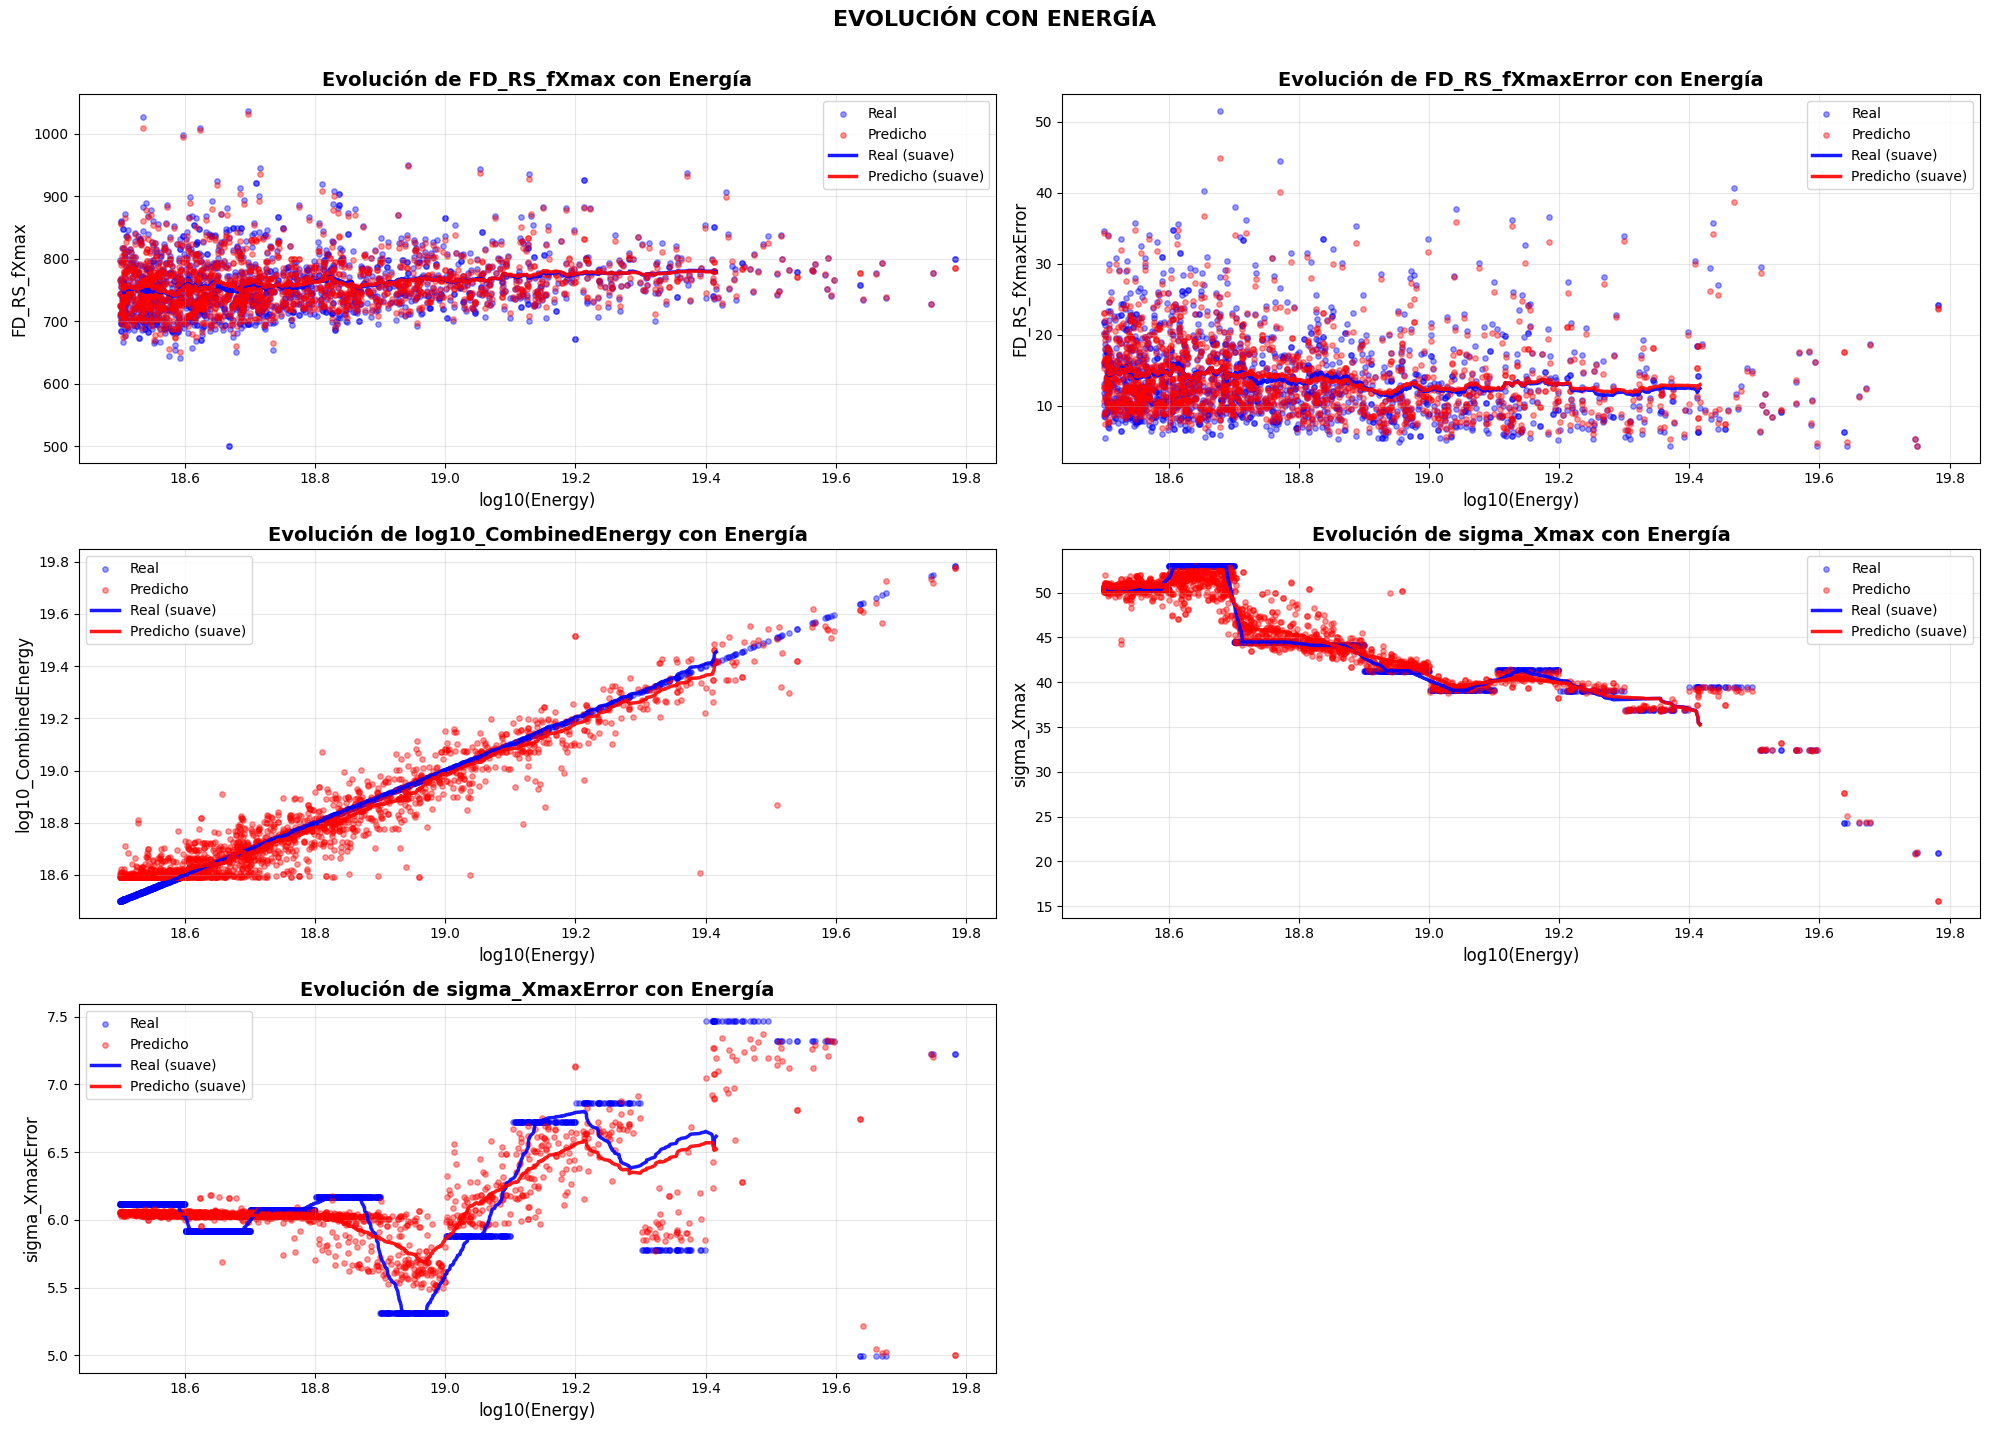

In [2]:

##VISUALIZAR RESULTADOS
print("\n" + "="*50)
print("GENERANDO VISUALIZACIONES")
print("="*50)

# Gráfica 1: Predicción vs Real
plt.figure(figsize=(20, 15))
for i, target in enumerate(target_names):
    plt.subplot(3, 2, i + 1)
    scatter = plt.scatter(y_test.iloc[:, i], y_pred_df.iloc[:, i], c=test_energies, cmap="viridis", alpha=0.6, s=20)
    plt.colorbar(scatter, label='log10(Energy)')
    min_val = min(y_test.iloc[:, i].min(), y_pred_df.iloc[:, i].min())
    max_val = max(y_test.iloc[:, i].max(), y_pred_df.iloc[:, i].max())
    #plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)
    plt.xlabel(f'Real {target}', fontsize=12)
    plt.ylabel(f'Predicho {target}', fontsize=12)
    plt.title(f'{target}\nR² = {r2_score(y_test.iloc[:, i], y_pred_df.iloc[:, i]):.3f}', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('PREDICCIONES vs VALORES REALES', fontsize=16, fontweight='bold')
#plt.savefig('prediccion_vs_real.png')
plt.show()
#plt.close()
print("Gráfica 'prediccion_vs_real.png' guardada.")

# Gráfica 2: Residuales
plt.figure(figsize=(20, 15))
for i, target in enumerate(target_names):
    plt.subplot(3, 2, i + 1)
    residuals = y_test.iloc[:, i] - y_pred_df.iloc[:, i]
    scatter = plt.scatter(y_pred_df.iloc[:, i], residuals, c=test_energies, cmap="plasma", alpha=0.6, s=20)
    plt.colorbar(scatter, label='log10(Energy)')
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.8, linewidth=2)
    plt.xlabel(f'Predicho {target}', fontsize=12)
    plt.ylabel('Residual (Real - Predicho)', fontsize=12)
    plt.title(f'Residuales - {target}', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('ANÁLISIS DE RESIDUALES', fontsize=16, fontweight='bold')
#plt.show()
#plt.savefig('analisis_residuales.png')
#plt.close()
print("Gráfica 'analisis_residuales.png' guardada.")

# Gráfica 3: Evolución con Energía
plt.figure(figsize=(20, 15))
for i, target in enumerate(target_names):
    plt.subplot(3, 2, i + 1)
    sort_idx = np.argsort(test_energies)
    sorted_energies = test_energies[sort_idx]
    sorted_real = y_test.iloc[:, i].values[sort_idx]
    sorted_pred = y_pred_df.iloc[:, i].values[sort_idx]
    plt.scatter(sorted_energies, sorted_real, alpha=0.4, s=15, label='Real', color='blue')
    plt.scatter(sorted_energies, sorted_pred, alpha=0.4, s=15, label='Predicho', color='red')
    window = max(1, len(sorted_energies) // 20)
    if window > 1:
        real_smooth = pd.Series(sorted_real).rolling(window=window, center=True).mean()
        pred_smooth = pd.Series(sorted_pred).rolling(window=window, center=True).mean()
        plt.plot(sorted_energies, real_smooth, 'b-', linewidth=2.5, alpha=0.9, label='Real (suave)')
        plt.plot(sorted_energies, pred_smooth, 'r-', linewidth=2.5, alpha=0.9, label='Predicho (suave)')
    plt.xlabel('log10(Energy)', fontsize=12)
    plt.ylabel(target, fontsize=12)
    plt.title(f'Evolución de {target} con Energía', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('EVOLUCIÓN CON ENERGÍA', fontsize=16, fontweight='bold')
#plt.show()
#plt.savefig('evolucion_con_energia.png')
#plt.close()
print("Gráfica 'evolucion_con_energia.png' guardada.")


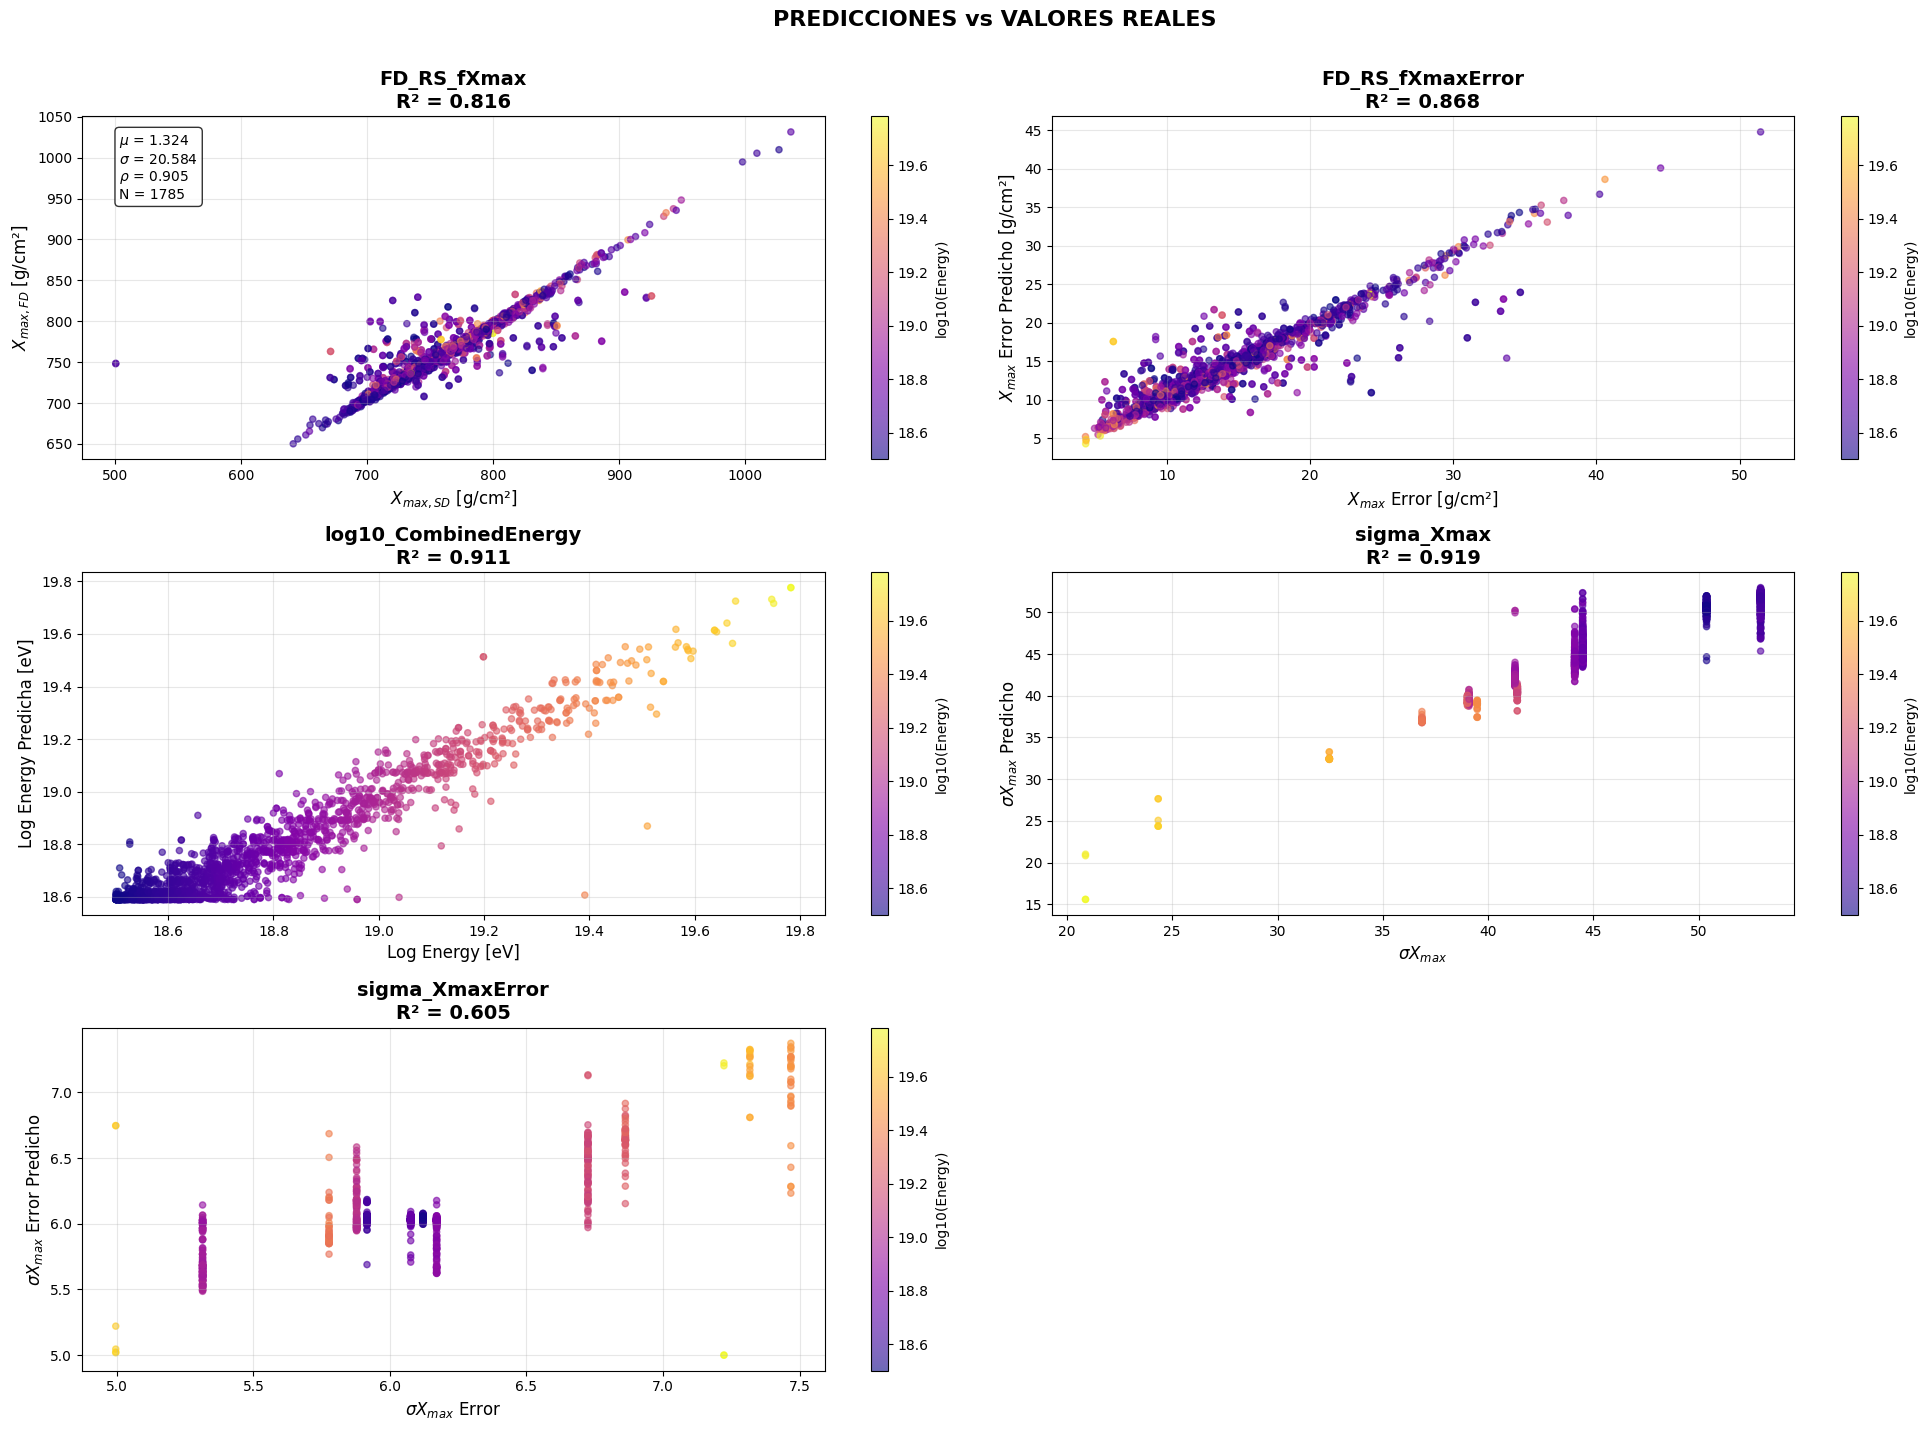

In [3]:
from scipy.stats import pearsonr
# Define nombres personalizados para los ejes
nombres_ejes_x = [
    '$X_{max,SD}$ [g/cm²]',
    '$X_{max}$ Error [g/cm²]',
    'Log Energy [eV]',
    r'$\sigma X_{max}$',
    r'$\sigma X_{max}$ Error',
]

nombres_ejes_y = [
    '$X_{max,FD}$ [g/cm²]',
    '$X_{max}$ Error Predicho [g/cm²]',
    'Log Energy Predicha [eV]',
    r'$\sigma X_{max}$ Predicho',
    r'$\sigma X_{max}$ Error Predicho',
]

plt.figure(figsize=(20, 15))

for i, target in enumerate(target_names):
    plt.subplot(3, 2, i + 1)
    scatter = plt.scatter(y_test.iloc[:, i], y_pred_df.iloc[:, i], c=test_energies, cmap="plasma", alpha=0.6, s=20)
    plt.colorbar(scatter, label='log10(Energy)')
    plt.xlabel(nombres_ejes_x[i], fontsize=12)
    plt.ylabel(nombres_ejes_y[i], fontsize=12)
    
    # Calcular métricas estadísticas
    residuals = y_pred_df.iloc[:, i] - y_test.iloc[:, i]
    bias = np.mean(residuals)
    resolution = np.std(residuals)
    pearson_corr = pearsonr(y_test.iloc[:, i], y_pred_df.iloc[:, i])[0]
    n_events = len(y_test.iloc[:, i])
    
    # Solo mostrar métricas en la gráfica de FD_RS_fXmax (primer subplot)
    if i == 0:  # FD_RS_fXmax es el primer target
        stats_text = f'$\\mu$ = {bias:.3f}\n$\\sigma$ = {resolution:.3f}\n$\\rho$ = {pearson_corr:.3f}\nN = {n_events}'
        plt.annotate(stats_text, xy=(0.05, 0.95), xycoords='axes fraction', 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                    fontsize=10, verticalalignment='top')
    
    plt.title(f'{target}\nR² = {r2_score(y_test.iloc[:, i], y_pred_df.iloc[:, i]):.3f}', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('PREDICCIONES vs VALORES REALES', fontsize=16, fontweight='bold')
plt.show()

Modelo para FD_RS_fXmax cargado exitosamente
Modelo para FD_RS_fXmaxError cargado exitosamente
Modelo para log10_CombinedEnergy cargado exitosamente
Modelo para sigma_Xmax cargado exitosamente
Modelo para sigma_XmaxError cargado exitosamente
Scaler cargado exitosamente
Targets: ['FD_RS_fXmax', 'FD_RS_fXmaxError', 'log10_CombinedEnergy', 'sigma_Xmax', 'sigma_XmaxError']
Datos cargados: 67931 eventos
Creando la característica NUMÉRICA 'energy_bin'...
Valores faltantes imputados
Características para energía: 74
Características para sigmas: 75
Características completas: 78
Prediciendo FD_RS_fXmax...
  → Usando conjunto FÍSICO (77 características)
Prediciendo FD_RS_fXmaxError...
  → Usando conjunto FÍSICO (77 características)
Prediciendo log10_CombinedEnergy...
  → Usando conjunto para ENERGÍA (74 características)
Prediciendo sigma_Xmax...
  → Usando conjunto para SIGMAS (75 características)
Prediciendo sigma_XmaxError...
  → Usando conjunto para SIGMAS (75 características)

Predicciones co

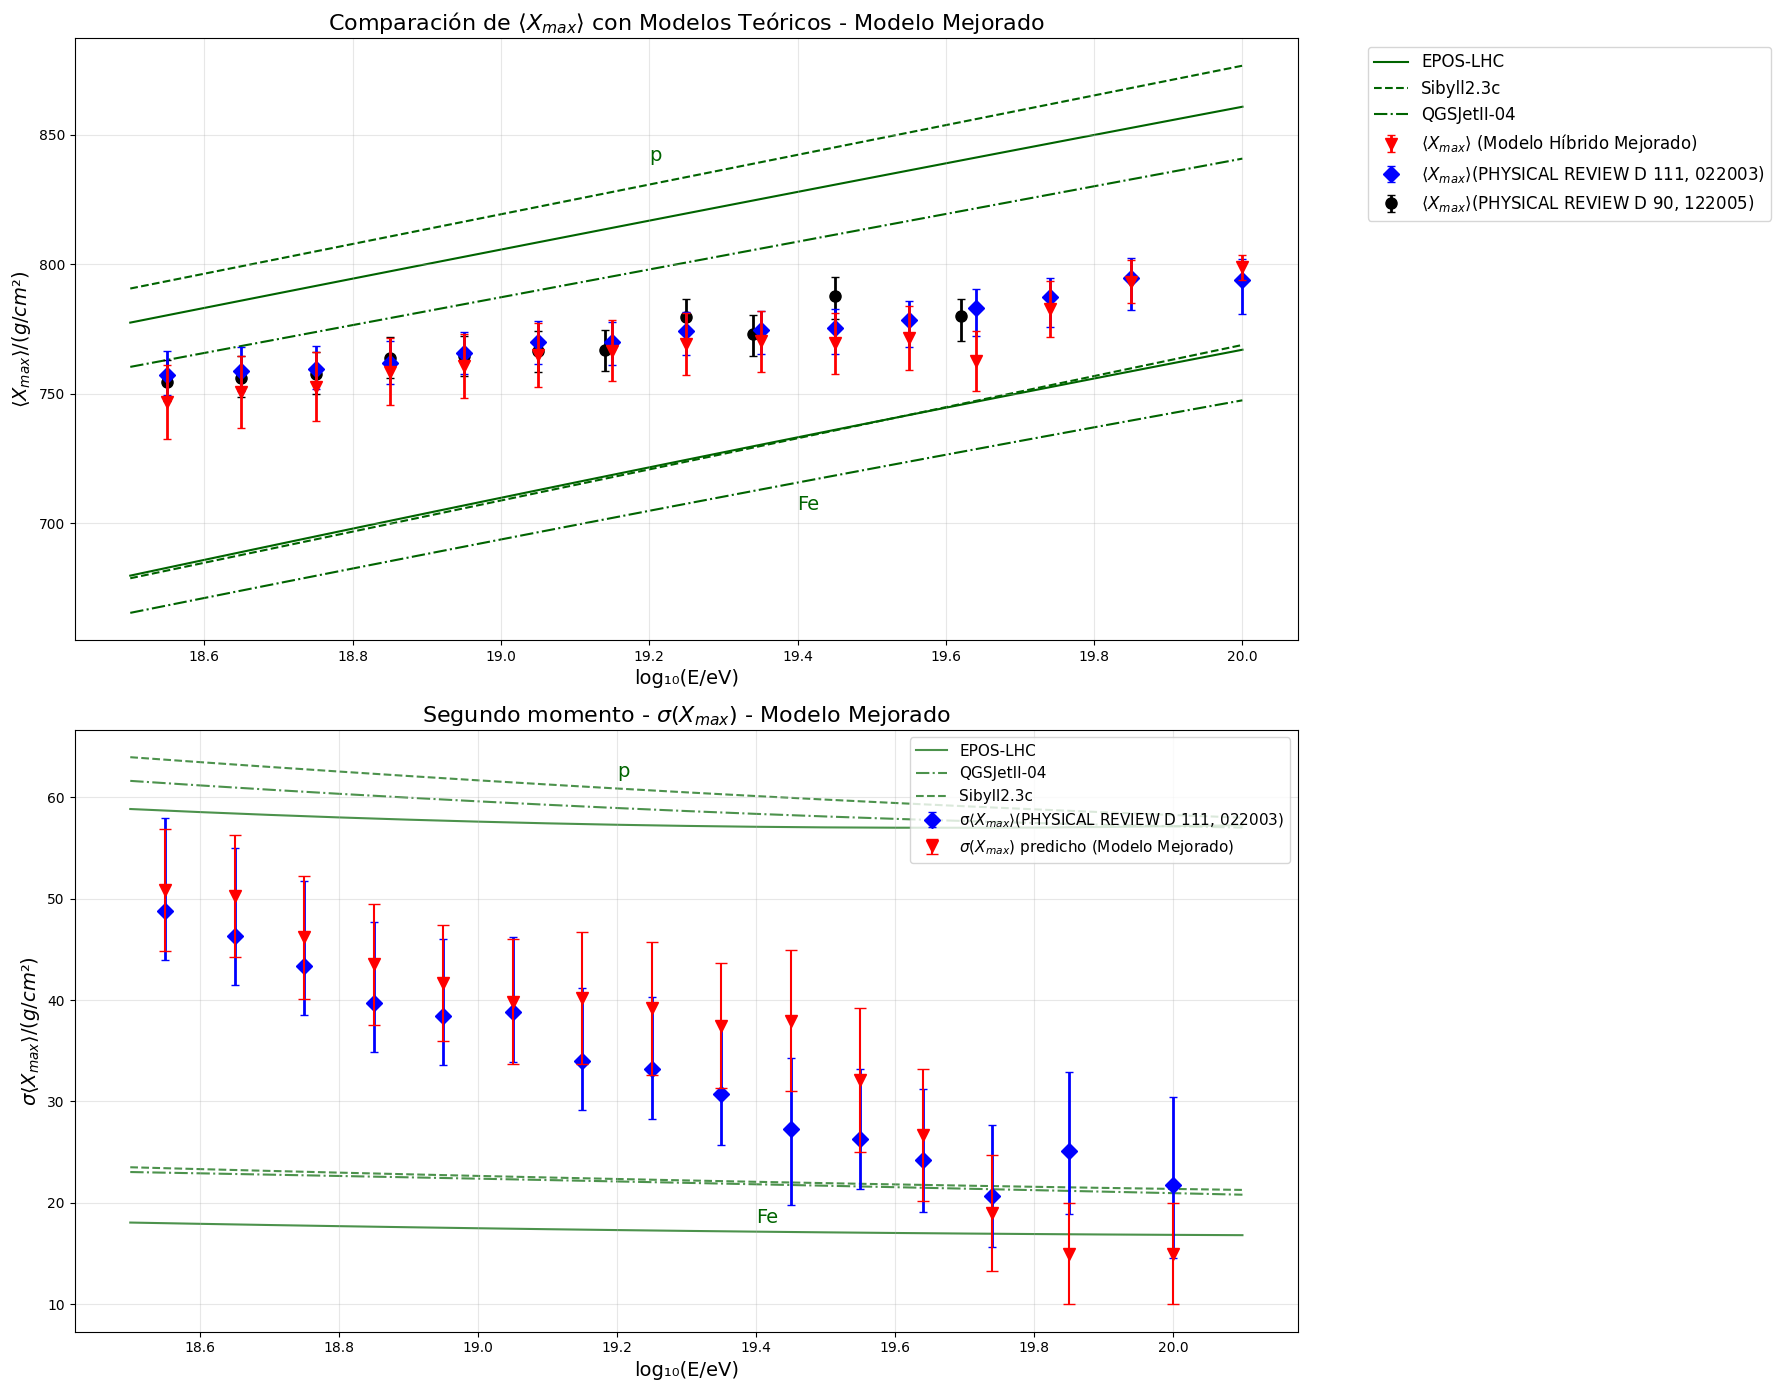


ESTADÍSTICAS DE PREDICCIÓN - MODELO MEJORADO
📊 Total de eventos procesados: 67931
⚡ Rango de energía: 18.59 - 20.08
📈 Xmax promedio: 752.9 ± 25.6 g/cm²
📊 sigma_Xmax promedio: 47.4 ± 4.6 g/cm²

🔬 PREDICCIONES EN ALTA ENERGÍA (>19.7):
   Eventos: 141
   sigma_Xmax promedio: 17.3 g/cm²
   sigma_Xmax mínimo: 15.0 g/cm²
   sigma_Xmax máximo: 32.1 g/cm²

⏱️  Tiempo total de ejecución: 41.07 segundos
✅ Predicción completada exitosamente!


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import time

# Registrar el tiempo de inicio
start_time = time.time()

# ================================
# 1. Carga del modelo híbrido MEJORADO - MODIFICADO
# ================================
try:
    # Cargar modelos individuales en lugar del archivo comprimido
    hybrid_models = {}
    target_names = ["FD_RS_fXmax", "FD_RS_fXmaxError", "log10_CombinedEnergy", "sigma_Xmax", "sigma_XmaxError"]
    
    for target in target_names:
        try:
            hybrid_models[target] = joblib.load(f'HM4CC_{target}.pkl')
            print(f"Modelo para {target} cargado exitosamente")
        except FileNotFoundError:
            print(f"Advertencia: No se encontró hybrid_model_{target}.pkl")
    
    # Cargar el scaler
    scaler = joblib.load('scaler.pkl')
    print("Scaler cargado exitosamente")
    
    # Definir las características a eliminar (basado en el código original)
    energy_features_to_drop = ['logE', 'logE_squared', 'logE_cubed', 'energy_bin']
    sigma_features_to_drop = ['logE', 'logE_squared', 'logE_cubed']
    
    print(f"Targets: {target_names}")
    
except Exception as e:
    raise RuntimeError(f"Error al cargar el modelo híbrido: {str(e)}")

# ================================
# 2. Predicción en nuevos datos de SD - VERSIÓN MEJORADA - MODIFICADO
# ================================
try:
    dfSD_nuevo = pd.read_csv("/home2/DSMaster/evarela/Andrea/SDnewversion.csv")
    
    # Filtrar datos de energía
    dfSD_nuevo = dfSD_nuevo[
        (dfSD_nuevo["SD_RS_fEnergy"] >= 10**18.5) & 
        (dfSD_nuevo["SD_RS_fEnergy"] <= 10**20)
    ].copy()
    
    print(f"Datos cargados: {len(dfSD_nuevo)} eventos")
    
    # Preparar características (deben coincidir con las usadas en entrenamiento)
    # MODIFICADO: Mantener solo las columnas que existen
    columns_to_drop = []
    for col in ["FD_RS_fXmax", "FD_RS_fXmaxError", "Energy_SD_FD", 
                "FD_RS_fEnergy", "FD_RS_fEnergyError", "logE", "sigma_Xmax"]:
        if col in dfSD_nuevo.columns:
            columns_to_drop.append(col)
    
    X_new = dfSD_nuevo.drop(columns=columns_to_drop, errors='ignore')
    
    # Añadir características de energía - MODIFICADO
    X_new['logE'] = np.log10(dfSD_nuevo["SD_RS_fEnergy"])
    X_new['logE_squared'] = X_new['logE']**2
    X_new['logE_cubed'] = X_new['logE']**3
    
    # Añadir energy_bin (necesario para modelos de sigma) - NUEVO
    print("Creando la característica NUMÉRICA 'energy_bin'...")
    energy_bins_for_feature = np.array([18.5, 19.0, 19.3, 19.5, 19.7, 19.8, 19.9, 20.0, np.inf])
    X_new['energy_bin'] = np.digitize(X_new['logE'], bins=energy_bins_for_feature)
    
    # Manejo de valores faltantes - MODIFICADO
    if X_new.isna().any().any():
        from sklearn.impute import SimpleImputer
        imputer = SimpleImputer(strategy='median')
        X_new_imputed = pd.DataFrame(imputer.fit_transform(X_new), columns=X_new.columns)
        print("Valores faltantes imputados")
    else:
        X_new_imputed = X_new.copy()
        print("No se encontraron valores faltantes")
    
    # Normalización (excepto características de energía) - MODIFICADO
    cols_to_scale = [col for col in X_new_imputed.columns 
                    if col not in ['logE', 'logE_squared', 'logE_cubed', 'energy_bin']]
    X_new_scaled = X_new_imputed.copy()
    if cols_to_scale:  # Solo escalar si hay columnas para escalar
        X_new_scaled[cols_to_scale] = scaler.transform(X_new_imputed[cols_to_scale])
    
    # Obtener energías para predicción híbrida
    energies_new = X_new_scaled['logE'].values
    
    # Crear conjuntos de características específicos - MODIFICADO
    X_new_for_energy = X_new_scaled.drop(columns=energy_features_to_drop, errors='ignore')
    X_new_for_sigma = X_new_scaled.drop(columns=sigma_features_to_drop, errors='ignore')
    X_new_no_bin = X_new_scaled.drop(columns=['energy_bin'], errors='ignore')
    
    print(f"Características para energía: {X_new_for_energy.shape[1]}")
    print(f"Características para sigmas: {X_new_for_sigma.shape[1]}")
    print(f"Características completas: {X_new_scaled.shape[1]}")
    
    # Predecir con modelo híbrido MEJORADO - MODIFICADO
    predictions_list = []
    
    for target in target_names:
        if target not in hybrid_models:
            print(f"Advertencia: No hay modelo para {target}, usando valores predeterminados")
            predictions_list.append(np.zeros(len(X_new_scaled)))
            continue
            
        print(f"Prediciendo {target}...")
        model = hybrid_models[target]
        
        # Seleccionar el conjunto de características correcto (EVITANDO FUGAS) - MODIFICADO
        if target == "log10_CombinedEnergy":
            # Para energía: eliminar características de energía y bin
            current_X_pred = X_new_for_energy.values
            print(f"  → Usando conjunto para ENERGÍA ({current_X_pred.shape[1]} características)")
        elif target in ["sigma_Xmax", "sigma_XmaxError"]:
            # Para sigmas: usar conjunto específico (con energy_bin)
            current_X_pred = X_new_for_sigma.values
            print(f"  → Usando conjunto para SIGMAS ({current_X_pred.shape[1]} características)")
        else:
            # Para FD_RS_fXmax y FD_RS_fXmaxError: usar sin energy_bin pero con características de energía
            current_X_pred = X_new_no_bin.values
            print(f"  → Usando conjunto FÍSICO ({current_X_pred.shape[1]} características)")
        
        pred = model.predict(current_X_pred, energies_new)
        predictions_list.append(pred)
    
    predictions = np.column_stack(predictions_list)
    
    # Agregar predicciones al DataFrame
    results_df = dfSD_nuevo.copy()
    results_df["Pred_Xmax"] = predictions[:, 0]
    results_df["Pred_Xmax_Error"] = predictions[:, 1]
    results_df["Pred_logE"] = predictions[:, 2]
    results_df["Pred_sigma_Xmax"] = predictions[:, 3]
    results_df["Pred_sigma_XmaxError"] = predictions[:, 4]
    
    print(f"\nPredicciones completadas para {len(results_df)} eventos")
    print(f"Rango de energía predicho: {results_df['Pred_logE'].min():.2f} - {results_df['Pred_logE'].max():.2f}")

except Exception as e:
    raise RuntimeError(f"Error durante la predicción: {str(e)}")

# ================================
# 3. Calcular valores promedios por intervalo de energía
# ================================
energy_points = np.array([18.55, 18.65, 18.75, 18.85, 18.95, 19.05, 
                          19.15, 19.25, 19.35, 19.45, 19.55, 19.64, 
                          19.74, 19.85, 20.00])

xmax_points = []
xmax_error_points = []
sigma_points = []
sigma_error_points = []

print("\nCalculando promedios por bins de energía...")
for i, energy in enumerate(energy_points):
    mask = (results_df["Pred_logE"] >= energy - 0.05) & \
           (results_df["Pred_logE"] < energy + 0.05)
    
    if mask.sum() > 0:
        xmax_points.append(np.mean(results_df.loc[mask, "Pred_Xmax"]))
        xmax_error_points.append(np.mean(results_df.loc[mask, "Pred_Xmax_Error"]))
        sigma_points.append(np.mean(results_df.loc[mask, "Pred_sigma_Xmax"]))
        sigma_error_points.append(np.mean(results_df.loc[mask, "Pred_sigma_XmaxError"]))
        print(f"  Bin {energy}: {mask.sum()} eventos, σ_Xmax = {sigma_points[-1]:.1f}")
    else:
        xmax_points.append(np.nan)
        xmax_error_points.append(np.nan)
        sigma_points.append(np.nan)
        sigma_error_points.append(np.nan)
        print(f"  Bin {energy}: 0 eventos")

# Ajuste de Xmax (si es necesario)
valor_a_sumar = 0
xmax_points_ajustados = np.array(xmax_points) + valor_a_sumar

# ================================
# 4. GRÁFICAS MEJORADAS
# ================================
plt.figure(figsize=(18, 14))

# Subgráfico 1: Comparación de Xmax
plt.subplot(2, 1, 1)
plt.errorbar(energy_points, xmax_points_ajustados, yerr=xmax_error_points, 
             color="red", ecolor='red', elinewidth=2, markersize=8, 
             zorder=4, capsize=3, fmt='v', 
             label='$⟨X_{max}⟩$ (Modelo Híbrido Mejorado)')

# [El resto del código de gráficas permanece igual...]
# Datos de referencia 1
x_points = [18.55, 18.65, 18.75, 18.85, 18.95, 19.05, 19.15, 19.25, 19.35, 19.45, 19.55, 19.64, 19.74, 19.85, 20.00]
y_points = [757.0, 758.8, 759.5, 761.8, 765.7, 770.0, 769.9, 774.0, 774.7, 775.3, 778.6, 783.2, 787.2, 794.5, 793.9]

y_error_asymmetric = [
    [7.7, 9.6], [7.8, 9.2], [7.9, 8.8], [8.0, 8.5], [8.2, 8.2],
    [8.4, 7.9], [8.7, 7.7], [9.1, 7.5], [9.5, 7.4], [10.0, 7.3],
    [10.5, 7.3], [11.0, 7.3], [11.6, 7.5], [12.2, 7.8], [13.1, 8.3]
]

plt.errorbar(
    x_points, y_points, 
    yerr=[np.array([lower for lower, upper in y_error_asymmetric]),
          np.array([upper for lower, upper in y_error_asymmetric])],
    fmt='D', color='blue', ecolor='blue', elinewidth=2, capsize=3,
    label="$⟨X_{max}⟩$(PHYSICAL REVIEW D 111, 022003)", markersize=8, zorder=3
)

# Modelos teóricos para Xmax
def RailsFunc(lgE, p):
    return p[0] + p[1] * (lgE - 18.) + p[2] * (lgE - 18.) ** 2

def GetModelRails():
    return {
        'EPOS-LHC': {'H': {'mean': [748.78, 57.73, -0.85]}, 'Fe': {'mean': [648.60, 63.12, -1.97]}},
        'Sibyll2.3c': {'H': {'mean': [761.9, 57.4, -8.07e-10]}, 'Fe': {'mean': [648.6, 60.1, -0.00016]}},
        'QGSJetII-04': {'H': {'mean': [733.34, 54.05, -0.16]}, 'Fe': {'mean': [635.93, 59.70, -1.98]}}
    }

lgE = np.linspace(18.5, 20, 100)
models = GetModelRails()
styles = {
    'EPOS-LHC': {'H': {'color': 'darkgreen', 'linestyle': '-'}, 
                 'Fe': {'color': 'darkgreen', 'linestyle': '-'}},
    'Sibyll2.3c': {'H': {'color': 'darkgreen', 'linestyle': '--'}, 
                   'Fe': {'color': 'darkgreen', 'linestyle': '--'}},
    'QGSJetII-04': {'H': {'color': 'darkgreen', 'linestyle': '-.'}, 
                    'Fe': {'color': 'darkgreen', 'linestyle': '-.'}}
}

for model, particles in models.items():
    for particle, params in particles.items():
        if model == 'Sibyll2.3c' and particle == 'H':
            label = '_nolegend_'
        elif model == 'EPOS-LHC' and particle == 'H':
            label = '_nolegend_'
        elif model == 'QGSJetII-04' and particle == 'H':
            label = '_nolegend_'
        else:
            label = model
        plt.plot(
            lgE, 
            RailsFunc(lgE, params['mean']), 
            color=styles[model][particle]['color'], 
            linestyle=styles[model][particle]['linestyle'],
            label=f"{label}",
            zorder=1
        )

# Datos de referencia 2
x_point = [18.55, 18.65, 18.75, 18.85, 18.95, 19.05, 19.14, 19.25, 19.34, 19.45, 19.62]
y_point = [754.5, 756.1, 757.4, 763.6, 764.6, 766.4, 767.0, 779.5, 773.1, 787.9, 779.8]
y_error_asymm = [[7.5,8.5], [7.5,8.5], [7.5,8.5], [7.7,8.1], [7.8,7.8], [8.0,7.6],
                [8.2,7.4], [8.5,7.2], [8.7,7.1], [8.9,7.0], [9.4,6.9]]

plt.errorbar(
    x_point, y_point, 
    yerr=[np.array([lower for lower, upper in y_error_asymm]),
          np.array([upper for lower, upper in y_error_asymm])],
    fmt='o', color='black', ecolor='black', elinewidth=2, capsize=3,
    label="$⟨X_{max}⟩$(PHYSICAL REVIEW D 90, 122005)", markersize=8, zorder=2
)

plt.text(19.2, 840, "p", fontsize=14, color="darkgreen")
plt.text(19.4, 705, "Fe", fontsize=14, color="darkgreen")
plt.xlabel('log₁₀(E/eV)', fontsize=14)
plt.ylabel('$⟨X_{max}⟩ / (g/cm²)$', fontsize=14)
plt.title('Comparación de $⟨X_{max}⟩$ con Modelos Teóricos - Modelo Mejorado', fontsize=16)
plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Subgráfico 2: sigma_Xmax vs Energía - GRÁFICA MEJORADA
plt.subplot(2, 1, 2)

# Función para modelos teóricos de sigma
def GetModelRails_sigma():
    ModelTrails = {}
    
    ModelTrails['EPOS-LHC'] = {}
    ModelTrails['EPOS-LHC']['H'] = {}
    ModelTrails['EPOS-LHC']['H']['mean'] = [748.7824192267246, 57.72752933739214, -0.8492819413608501]
    ModelTrails['EPOS-LHC']['H']['sigma']= [ 60.754568341320265, -4.523514085098007, 1.3561246418133817]
    ModelTrails['EPOS-LHC']['Fe'] = {}
    ModelTrails['EPOS-LHC']['Fe']['mean'] = [648.6042870553292, 63.12370268046462, -1.971476995005652]
    ModelTrails['EPOS-LHC']['Fe']['sigma'] = [18.78185209432394, -1.5909852848013866, 0.3130051586485538]
    
    ModelTrails['QGSJetII-04'] = {}
    ModelTrails['QGSJetII-04']['H'] = {}
    ModelTrails['QGSJetII-04']['H']['mean'] = [733.3361855074645, 54.047662455592985, -0.16135288252029056]
    ModelTrails['QGSJetII-04']['H']['sigma'] = [64.14678054632051, -5.60721479996932, 1.0494756541917634]
    ModelTrails['QGSJetII-04']['Fe'] = {}
    ModelTrails['QGSJetII-04']['Fe']['mean'] = [635.9311237461296, 59.70402610426705, -1.9779302901269205]
    ModelTrails['QGSJetII-04']['Fe']['sigma'] = [23.662014632248354, -1.1934827895137259, -0.07813472862728368]
    
    ModelTrails['Sibyll2.3c'] = {}
    ModelTrails['Sibyll2.3c']['H'] = {}
    ModelTrails['Sibyll2.3c']['H']['mean'] = [761.9, 57.4, -8.07e-10]
    ModelTrails['Sibyll2.3c']['H']['sigma'] = [66.6, -5.7, 0.76] 
    ModelTrails['Sibyll2.3c']['Fe'] = {}
    ModelTrails['Sibyll2.3c']['Fe']['mean'] = [656.6, 60.1, -0.00016]
    ModelTrails['Sibyll2.3c']['Fe']['sigma'] = [ 24.51, -2.13, 0.2824]
    
    return ModelTrails

# Obtenemos los modelos para sigma
models_sigma = GetModelRails_sigma()

# Definimos los estilos para cada modelo y partícula
styles_sigma = {
    'EPOS-LHC': {'H': {'color': 'darkgreen', 'linestyle': '-'}, 
                 'Fe': {'color': 'darkgreen', 'linestyle': '-'}},
    'Sibyll2.3c': {'H': {'color': 'darkgreen', 'linestyle': '--'}, 
                   'Fe': {'color': 'darkgreen', 'linestyle': '--'}},
    'QGSJetII-04': {'H': {'color': 'darkgreen', 'linestyle': '-.'}, 
                    'Fe': {'color': 'darkgreen', 'linestyle': '-.'}}
}

# Rango de energías para plotear las curvas de sigma
lgE_sigma = np.arange(18.5, 20.1, 0.1)

# Plotear las curvas de los modelos teóricos para sigma
for model, particles in models_sigma.items():
    for particle, params in particles.items():
        if particle == 'sigma':  # Saltar las entradas de sigma
            continue
        # Para sigma, usamos los parámetros de sigma
        sigma_params = models_sigma[model][particle]['sigma']
        plt.plot(
            lgE_sigma, 
            RailsFunc(lgE_sigma, sigma_params), 
            color=styles_sigma[model][particle]['color'], 
            linestyle=styles_sigma[model][particle]['linestyle'],
            label=f"{model}" if particle == "H" else (""),
            zorder=1,
            alpha=0.7
        )

# Datos experimentales de sigma
x_points_sigma = [18.55, 18.65, 18.75, 18.85, 18.95, 19.05, 19.15, 19.25, 19.35, 19.45, 19.55, 19.64, 19.74, 19.85, 20.00]
y_points_sigma = [48.8, 46.3, 43.4, 39.7, 38.4, 38.8, 34.0, 33.2, 30.7, 27.3, 26.3, 24.2, 20.7, 25.1, 21.8]

# Errores estadísticos (simétricos, uno por punto)
error_stat = [0.6, 0.6, 0.7, 0.6, 0.7, 1.0, 0.8, 0.9, 1.2, 1.6, 1.3, 1.8, 1.4, 3.9, 5.4]

# Errores sistemáticos (asimétricos, pares [lower, upper] por punto)
error_syst = [
    [4.8, 9.1], [4.8, 8.7], [4.8, 8.3], [4.8, 8.0], [4.8, 7.6],
    [4.8, 7.3], [4.8, 7.1], [4.8, 7.0], [4.8, 6.9], [7.3, 6.8],
    [4.8, 6.8], [4.8, 6.8], [4.8, 6.8], [4.8, 6.8], [4.8, 6.8]
]

# Separar errores sistemáticos en componentes lower/upper
error_syst_lower = [e[0] for e in error_syst]
error_syst_upper = [e[1] for e in error_syst]

# Calcular errores TOTALES (combinación cuadrática de estadístico + sistemático)
total_error_lower = np.sqrt(np.array(error_stat)**2 + np.array(error_syst_lower)**2)
total_error_upper = np.sqrt(np.array(error_stat)**2 + np.array(error_syst_upper)**2)

# Plotear datos experimentales de sigma
plt.errorbar(
    x_points_sigma, y_points_sigma,
    yerr=[total_error_lower, total_error_upper],  # Errores totales asimétricos
    fmt='D', color='blue', ecolor='blue', elinewidth=2, capsize=3,
    label="σ$⟨X_{max}⟩$(PHYSICAL REVIEW D 111, 022003)", markersize=8, zorder=3
)

# Plotear predicciones del modelo MEJORADO (usando errores predichos)
plt.errorbar(energy_points, sigma_points, 
             yerr=sigma_error_points,  # Usar Pred_sigma_XmaxError del modelo
             fmt='v', color='red', ecolor='red', markersize=8,
             capsize=4, zorder=4, label='$\sigma(X_{max})$ predicho (Modelo Mejorado)')

# Añadir texto para identificar protones y hierro
plt.text(19.2, 62, "p", fontsize=14, color="darkgreen")
plt.text(19.4, 18, "Fe", fontsize=14, color="darkgreen")

plt.xlabel('log₁₀(E/eV)', fontsize=14)
plt.ylabel('$\sigma⟨X_{max}⟩ / (g/cm²)$', fontsize=14)
plt.title('Segundo momento - $\sigma(X_{max})$ - Modelo Mejorado', fontsize=16)
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ================================
# 5. ESTADÍSTICAS FINALES
# ================================
print("\n" + "="*60)
print("ESTADÍSTICAS DE PREDICCIÓN - MODELO MEJORADO")
print("="*60)

print(f"📊 Total de eventos procesados: {len(results_df)}")
print(f"⚡ Rango de energía: {results_df['Pred_logE'].min():.2f} - {results_df['Pred_logE'].max():.2f}")
print(f"📈 Xmax promedio: {results_df['Pred_Xmax'].mean():.1f} ± {results_df['Pred_Xmax'].std():.1f} g/cm²")
print(f"📊 sigma_Xmax promedio: {results_df['Pred_sigma_Xmax'].mean():.1f} ± {results_df['Pred_sigma_Xmax'].std():.1f} g/cm²")

# Mostrar valores específicos para alta energía
high_energy_mask = results_df['Pred_logE'] > 19.7
if high_energy_mask.sum() > 0:
    print(f"\n🔬 PREDICCIONES EN ALTA ENERGÍA (>19.7):")
    print(f"   Eventos: {high_energy_mask.sum()}")
    print(f"   sigma_Xmax promedio: {results_df.loc[high_energy_mask, 'Pred_sigma_Xmax'].mean():.1f} g/cm²")
    print(f"   sigma_Xmax mínimo: {results_df.loc[high_energy_mask, 'Pred_sigma_Xmax'].min():.1f} g/cm²")
    print(f"   sigma_Xmax máximo: {results_df.loc[high_energy_mask, 'Pred_sigma_Xmax'].max():.1f} g/cm²")

# Tiempo de ejecución
print(f"\n⏱️  Tiempo total de ejecución: {time.time() - start_time:.2f} segundos")
print("✅ Predicción completada exitosamente!")


Calculando promedios por bins de energía...
  Bin 18.55: 21914 eventos, σ_Xmax = 50.8
  Bin 18.65: 18751 eventos, σ_Xmax = 50.2
  Bin 18.75: 8982 eventos, σ_Xmax = 46.2
  Bin 18.85: 6398 eventos, σ_Xmax = 43.5
  Bin 18.95: 3907 eventos, σ_Xmax = 41.7
  Bin 19.05: 2799 eventos, σ_Xmax = 39.9
  Bin 19.15: 1941 eventos, σ_Xmax = 40.2
  Bin 19.25: 1392 eventos, σ_Xmax = 39.2
  Bin 19.35: 638 eventos, σ_Xmax = 37.5
  Bin 19.45: 557 eventos, σ_Xmax = 38.0
  Bin 19.55: 405 eventos, σ_Xmax = 32.1
  Bin 19.64: 91 eventos, σ_Xmax = 26.7
  Bin 19.74: 114 eventos, σ_Xmax = 19.0
  Bin 19.85: 31 eventos, σ_Xmax = 15.0
  Bin 20.0: 4 eventos, σ_Xmax = 15.0


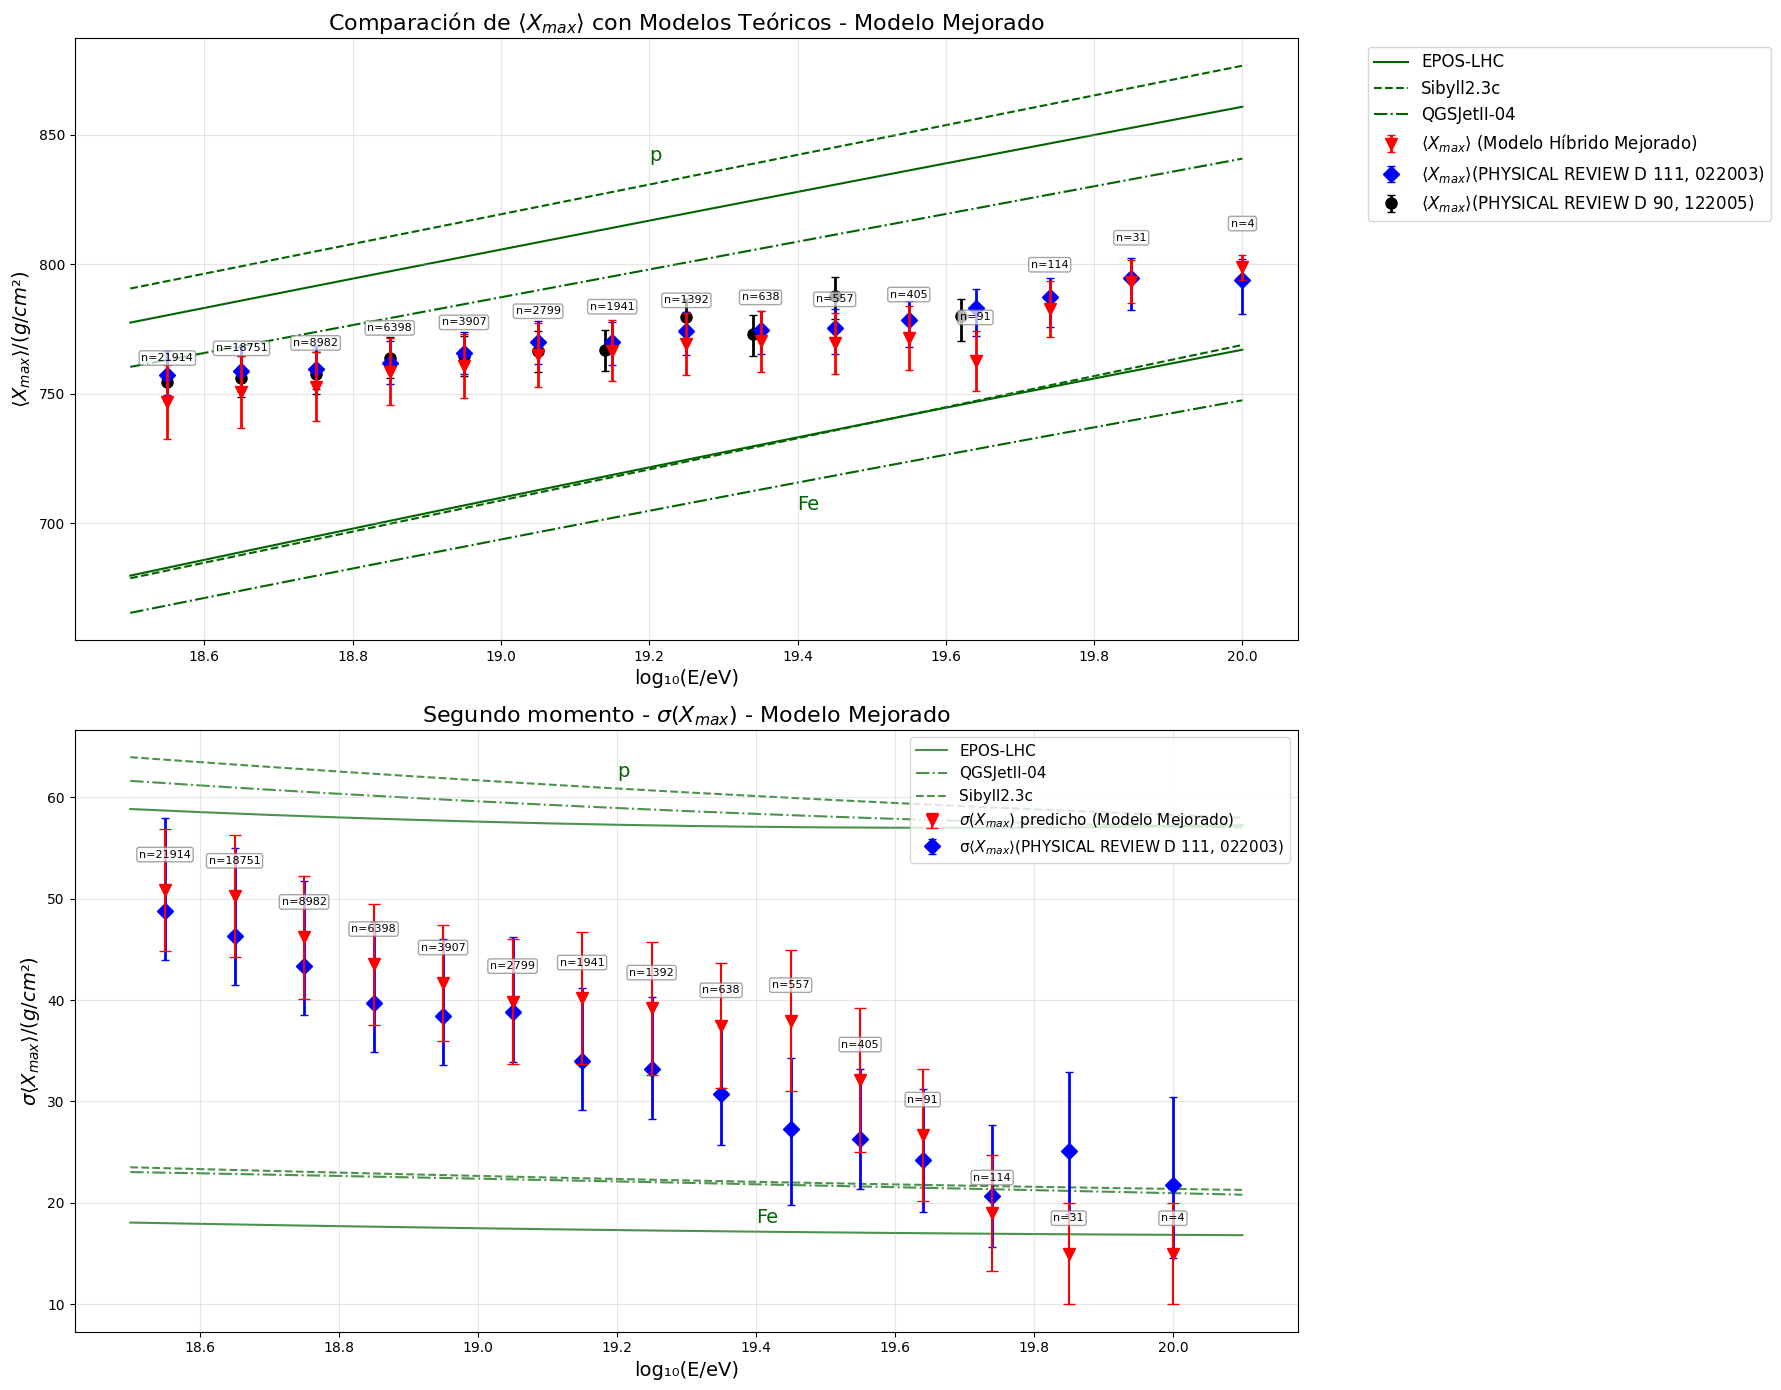

In [7]:
# ================================
# 3. Calcular valores promedios por intervalo de energía - MODIFICADO
# ================================
energy_points = np.array([18.55, 18.65, 18.75, 18.85, 18.95, 19.05, 
                          19.15, 19.25, 19.35, 19.45, 19.55, 19.64, 
                          19.74, 19.85, 20.00])

xmax_points = []
xmax_error_points = []
sigma_points = []
sigma_error_points = []
event_counts = []  # NUEVO: Lista para almacenar número de eventos por bin

print("\nCalculando promedios por bins de energía...")
for i, energy in enumerate(energy_points):
    mask = (results_df["Pred_logE"] >= energy - 0.05) & \
           (results_df["Pred_logE"] < energy + 0.05)
    
    event_count = mask.sum()  # NUEVO: Contar eventos en este bin
    event_counts.append(event_count)  # NUEVO: Guardar conteo
    
    if event_count > 0:
        xmax_points.append(np.mean(results_df.loc[mask, "Pred_Xmax"]))
        xmax_error_points.append(np.mean(results_df.loc[mask, "Pred_Xmax_Error"]))
        sigma_points.append(np.mean(results_df.loc[mask, "Pred_sigma_Xmax"]))
        sigma_error_points.append(np.mean(results_df.loc[mask, "Pred_sigma_XmaxError"]))
        print(f"  Bin {energy}: {event_count} eventos, σ_Xmax = {sigma_points[-1]:.1f}")
    else:
        xmax_points.append(np.nan)
        xmax_error_points.append(np.nan)
        sigma_points.append(np.nan)
        sigma_error_points.append(np.nan)
        print(f"  Bin {energy}: 0 eventos")

# Ajuste de Xmax (si es necesario)
valor_a_sumar = 0
xmax_points_ajustados = np.array(xmax_points) + valor_a_sumar

# ================================
# 4. GRÁFICAS MEJORADAS - MODIFICADO PARA MOSTRAR NÚMERO DE EVENTOS
# ================================
plt.figure(figsize=(18, 14))

# Subgráfico 1: Comparación de Xmax - MODIFICADO
plt.subplot(2, 1, 1)
# Primero plotear los puntos principales
main_plot = plt.errorbar(energy_points, xmax_points_ajustados, yerr=xmax_error_points, 
             color="red", ecolor='red', elinewidth=2, markersize=8, 
             zorder=4, capsize=3, fmt='v', 
             label='$⟨X_{max}⟩$ (Modelo Híbrido Mejorado)')

# NUEVO: Añadir texto con número de eventos sobre cada punto
for i, (energy, xmax_val, count) in enumerate(zip(energy_points, xmax_points_ajustados, event_counts)):
    if not np.isnan(xmax_val) and count > 0:
        # Posicionar el texto ligeramente arriba del punto
        y_offset = 15  # Ajusta este valor según necesites
        plt.text(energy, xmax_val + y_offset, f'n={count}', 
                fontsize=8, ha='center', va='bottom', 
                bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.7, edgecolor='gray'),
                zorder=5)

# [El resto del código de la primera gráfica permanece igual...]
# Datos de referencia 1
x_points = [18.55, 18.65, 18.75, 18.85, 18.95, 19.05, 19.15, 19.25, 19.35, 19.45, 19.55, 19.64, 19.74, 19.85, 20.00]
y_points = [757.0, 758.8, 759.5, 761.8, 765.7, 770.0, 769.9, 774.0, 774.7, 775.3, 778.6, 783.2, 787.2, 794.5, 793.9]

y_error_asymmetric = [
    [7.7, 9.6], [7.8, 9.2], [7.9, 8.8], [8.0, 8.5], [8.2, 8.2],
    [8.4, 7.9], [8.7, 7.7], [9.1, 7.5], [9.5, 7.4], [10.0, 7.3],
    [10.5, 7.3], [11.0, 7.3], [11.6, 7.5], [12.2, 7.8], [13.1, 8.3]
]

plt.errorbar(
    x_points, y_points, 
    yerr=[np.array([lower for lower, upper in y_error_asymmetric]),
          np.array([upper for lower, upper in y_error_asymmetric])],
    fmt='D', color='blue', ecolor='blue', elinewidth=2, capsize=3,
    label="$⟨X_{max}⟩$(PHYSICAL REVIEW D 111, 022003)", markersize=8, zorder=3
)

# Modelos teóricos para Xmax
def RailsFunc(lgE, p):
    return p[0] + p[1] * (lgE - 18.) + p[2] * (lgE - 18.) ** 2

def GetModelRails():
    return {
        'EPOS-LHC': {'H': {'mean': [748.78, 57.73, -0.85]}, 'Fe': {'mean': [648.60, 63.12, -1.97]}},
        'Sibyll2.3c': {'H': {'mean': [761.9, 57.4, -8.07e-10]}, 'Fe': {'mean': [648.6, 60.1, -0.00016]}},
        'QGSJetII-04': {'H': {'mean': [733.34, 54.05, -0.16]}, 'Fe': {'mean': [635.93, 59.70, -1.98]}}
    }

lgE = np.linspace(18.5, 20, 100)
models = GetModelRails()
styles = {
    'EPOS-LHC': {'H': {'color': 'darkgreen', 'linestyle': '-'}, 
                 'Fe': {'color': 'darkgreen', 'linestyle': '-'}},
    'Sibyll2.3c': {'H': {'color': 'darkgreen', 'linestyle': '--'}, 
                   'Fe': {'color': 'darkgreen', 'linestyle': '--'}},
    'QGSJetII-04': {'H': {'color': 'darkgreen', 'linestyle': '-.'}, 
                    'Fe': {'color': 'darkgreen', 'linestyle': '-.'}}
}

for model, particles in models.items():
    for particle, params in particles.items():
        if model == 'Sibyll2.3c' and particle == 'H':
            label = '_nolegend_'
        elif model == 'EPOS-LHC' and particle == 'H':
            label = '_nolegend_'
        elif model == 'QGSJetII-04' and particle == 'H':
            label = '_nolegend_'
        else:
            label = model
        plt.plot(
            lgE, 
            RailsFunc(lgE, params['mean']), 
            color=styles[model][particle]['color'], 
            linestyle=styles[model][particle]['linestyle'],
            label=f"{label}",
            zorder=1
        )

# Datos de referencia 2
x_point = [18.55, 18.65, 18.75, 18.85, 18.95, 19.05, 19.14, 19.25, 19.34, 19.45, 19.62]
y_point = [754.5, 756.1, 757.4, 763.6, 764.6, 766.4, 767.0, 779.5, 773.1, 787.9, 779.8]
y_error_asymm = [[7.5,8.5], [7.5,8.5], [7.5,8.5], [7.7,8.1], [7.8,7.8], [8.0,7.6],
                [8.2,7.4], [8.5,7.2], [8.7,7.1], [8.9,7.0], [9.4,6.9]]

plt.errorbar(
    x_point, y_point, 
    yerr=[np.array([lower for lower, upper in y_error_asymm]),
          np.array([upper for lower, upper in y_error_asymm])],
    fmt='o', color='black', ecolor='black', elinewidth=2, capsize=3,
    label="$⟨X_{max}⟩$(PHYSICAL REVIEW D 90, 122005)", markersize=8, zorder=2
)

plt.text(19.2, 840, "p", fontsize=14, color="darkgreen")
plt.text(19.4, 705, "Fe", fontsize=14, color="darkgreen")
plt.xlabel('log₁₀(E/eV)', fontsize=14)
plt.ylabel('$⟨X_{max}⟩ / (g/cm²)$', fontsize=14)
plt.title('Comparación de $⟨X_{max}⟩$ con Modelos Teóricos - Modelo Mejorado', fontsize=16)
plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Subgráfico 2: sigma_Xmax vs Energía - GRÁFICA MEJORADA - MODIFICADO
plt.subplot(2, 1, 2)

# Primero plotear los puntos principales
sigma_plot = plt.errorbar(energy_points, sigma_points, 
             yerr=sigma_error_points,  # Usar Pred_sigma_XmaxError del modelo
             fmt='v', color='red', ecolor='red', markersize=8,
             capsize=4, zorder=4, label='$\sigma(X_{max})$ predicho (Modelo Mejorado)')

# NUEVO: Añadir texto con número de eventos sobre cada punto de sigma
for i, (energy, sigma_val, count) in enumerate(zip(energy_points, sigma_points, event_counts)):
    if not np.isnan(sigma_val) and count > 0:
        # Posicionar el texto ligeramente arriba del punto
        y_offset = 3  # Ajusta este valor según necesites para sigma
        plt.text(energy, sigma_val + y_offset, f'n={count}', 
                fontsize=8, ha='center', va='bottom', 
                bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.7, edgecolor='gray'),
                zorder=5)

# [El resto del código de la segunda gráfica permanece igual...]
# Función para modelos teóricos de sigma
def GetModelRails_sigma():
    ModelTrails = {}
    
    ModelTrails['EPOS-LHC'] = {}
    ModelTrails['EPOS-LHC']['H'] = {}
    ModelTrails['EPOS-LHC']['H']['mean'] = [748.7824192267246, 57.72752933739214, -0.8492819413608501]
    ModelTrails['EPOS-LHC']['H']['sigma']= [ 60.754568341320265, -4.523514085098007, 1.3561246418133817]
    ModelTrails['EPOS-LHC']['Fe'] = {}
    ModelTrails['EPOS-LHC']['Fe']['mean'] = [648.6042870553292, 63.12370268046462, -1.971476995005652]
    ModelTrails['EPOS-LHC']['Fe']['sigma'] = [18.78185209432394, -1.5909852848013866, 0.3130051586485538]
    
    ModelTrails['QGSJetII-04'] = {}
    ModelTrails['QGSJetII-04']['H'] = {}
    ModelTrails['QGSJetII-04']['H']['mean'] = [733.3361855074645, 54.047662455592985, -0.16135288252029056]
    ModelTrails['QGSJetII-04']['H']['sigma'] = [64.14678054632051, -5.60721479996932, 1.0494756541917634]
    ModelTrails['QGSJetII-04']['Fe'] = {}
    ModelTrails['QGSJetII-04']['Fe']['mean'] = [635.9311237461296, 59.70402610426705, -1.9779302901269205]
    ModelTrails['QGSJetII-04']['Fe']['sigma'] = [23.662014632248354, -1.1934827895137259, -0.07813472862728368]
    
    ModelTrails['Sibyll2.3c'] = {}
    ModelTrails['Sibyll2.3c']['H'] = {}
    ModelTrails['Sibyll2.3c']['H']['mean'] = [761.9, 57.4, -8.07e-10]
    ModelTrails['Sibyll2.3c']['H']['sigma'] = [66.6, -5.7, 0.76] 
    ModelTrails['Sibyll2.3c']['Fe'] = {}
    ModelTrails['Sibyll2.3c']['Fe']['mean'] = [656.6, 60.1, -0.00016]
    ModelTrails['Sibyll2.3c']['Fe']['sigma'] = [ 24.51, -2.13, 0.2824]
    
    return ModelTrails

# Obtenemos los modelos para sigma
models_sigma = GetModelRails_sigma()

# Definimos los estilos para cada modelo y partícula
styles_sigma = {
    'EPOS-LHC': {'H': {'color': 'darkgreen', 'linestyle': '-'}, 
                 'Fe': {'color': 'darkgreen', 'linestyle': '-'}},
    'Sibyll2.3c': {'H': {'color': 'darkgreen', 'linestyle': '--'}, 
                   'Fe': {'color': 'darkgreen', 'linestyle': '--'}},
    'QGSJetII-04': {'H': {'color': 'darkgreen', 'linestyle': '-.'}, 
                    'Fe': {'color': 'darkgreen', 'linestyle': '-.'}}
}

# Rango de energías para plotear las curvas de sigma
lgE_sigma = np.arange(18.5, 20.1, 0.1)

# Plotear las curvas de los modelos teóricos para sigma
for model, particles in models_sigma.items():
    for particle, params in particles.items():
        if particle == 'sigma':  # Saltar las entradas de sigma
            continue
        # Para sigma, usamos los parámetros de sigma
        sigma_params = models_sigma[model][particle]['sigma']
        plt.plot(
            lgE_sigma, 
            RailsFunc(lgE_sigma, sigma_params), 
            color=styles_sigma[model][particle]['color'], 
            linestyle=styles_sigma[model][particle]['linestyle'],
            label=f"{model}" if particle == "H" else (""),
            zorder=1,
            alpha=0.7
        )

# Datos experimentales de sigma
x_points_sigma = [18.55, 18.65, 18.75, 18.85, 18.95, 19.05, 19.15, 19.25, 19.35, 19.45, 19.55, 19.64, 19.74, 19.85, 20.00]
y_points_sigma = [48.8, 46.3, 43.4, 39.7, 38.4, 38.8, 34.0, 33.2, 30.7, 27.3, 26.3, 24.2, 20.7, 25.1, 21.8]

# Errores estadísticos (simétricos, uno por punto)
error_stat = [0.6, 0.6, 0.7, 0.6, 0.7, 1.0, 0.8, 0.9, 1.2, 1.6, 1.3, 1.8, 1.4, 3.9, 5.4]

# Errores sistemáticos (asimétricos, pares [lower, upper] por punto)
error_syst = [
    [4.8, 9.1], [4.8, 8.7], [4.8, 8.3], [4.8, 8.0], [4.8, 7.6],
    [4.8, 7.3], [4.8, 7.1], [4.8, 7.0], [4.8, 6.9], [7.3, 6.8],
    [4.8, 6.8], [4.8, 6.8], [4.8, 6.8], [4.8, 6.8], [4.8, 6.8]
]

# Separar errores sistemáticos en componentes lower/upper
error_syst_lower = [e[0] for e in error_syst]
error_syst_upper = [e[1] for e in error_syst]

# Calcular errores TOTALES (combinación cuadrática de estadístico + sistemático)
total_error_lower = np.sqrt(np.array(error_stat)**2 + np.array(error_syst_lower)**2)
total_error_upper = np.sqrt(np.array(error_stat)**2 + np.array(error_syst_upper)**2)

# Plotear datos experimentales de sigma
plt.errorbar(
    x_points_sigma, y_points_sigma,
    yerr=[total_error_lower, total_error_upper],  # Errores totales asimétricos
    fmt='D', color='blue', ecolor='blue', elinewidth=2, capsize=3,
    label="σ$⟨X_{max}⟩$(PHYSICAL REVIEW D 111, 022003)", markersize=8, zorder=3
)

# Añadir texto para identificar protones y hierro
plt.text(19.2, 62, "p", fontsize=14, color="darkgreen")
plt.text(19.4, 18, "Fe", fontsize=14, color="darkgreen")

plt.xlabel('log₁₀(E/eV)', fontsize=14)
plt.ylabel('$\sigma⟨X_{max}⟩ / (g/cm²)$', fontsize=14)
plt.title('Segundo momento - $\sigma(X_{max})$ - Modelo Mejorado', fontsize=16)
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# [El resto del código permanece igual...]